# FINAL PROJECT

## Karpov.Courses

### Nikita Axenov

***

# TASK 1

## INITIAL DATA

During a test of a hypothesis **(! don't forget to name the H0 and H1 !)**
it was suggested to the **Test Group** to use a new site service payment mechanics.

It had been left for the **Control Group** to use the basic one.

Worth it or not to launch the new payment mechanics for all users?

## SOLVATION

In [1]:
import requests
from urllib.parse import urlencode

import pandas as pd
import seaborn as sns
import numpy as np

from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')

Firstly, collect suggested data.

In [2]:
# I ADDED FILES TO MY DISC AND GIVE LINKS TO MY COPIES
groups = 'https://disk.yandex.ru/d/kMrULQ9QCD7-CQ'
group_add = 'https://disk.yandex.ru/d/TCBybqETWA8f5Q'
active_students = 'https://disk.yandex.ru/d/p2vilpAQAjrfMQ'
checks = 'https://disk.yandex.ru/d/8Au59cjThCOLCQ'

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download'

In [4]:
# FOR GROUPS FILE
public_key = groups  # public link 

# get an url to download a file
response_url = f'{base_url}?public_key={public_key}'
the_response = requests.get(response_url)
loading_link = the_response.json()['href']

# download a file and save it
loaded_response = requests.get(loading_link)
with open('groups.csv', 'wb') as f:
    f.write(loaded_response.content)

In [5]:
# FOR GROUP ADD FILE
public_key = group_add  # public link 

# get an url to download a file
response_url = f'{base_url}?public_key={public_key}'
the_response = requests.get(response_url)
loading_link = the_response.json()['href']

# download a file and save it
loaded_response = requests.get(loading_link)
with open('group_add.csv', 'wb') as f:
    f.write(loaded_response.content)

In [6]:
# FOR ACTIVE STUDENTS FILE
public_key = active_students  # public link 

# get an url to download a file
response_url = f'{base_url}?public_key={public_key}'
the_response = requests.get(response_url)
loading_link = the_response.json()['href']

# download a file and save it
loaded_response = requests.get(loading_link)
with open('active_students.csv', 'wb') as f:
    f.write(loaded_response.content)

In [7]:
# FOR CHECKS FILE
public_key = checks  # public link 

# get an url to download a file
response_url = f'{base_url}?public_key={public_key}'
the_response = requests.get(response_url)
loading_link = the_response.json()['href']

# download a file and save it
loaded_response = requests.get(loading_link)
with open('checks.csv', 'wb') as f:
    f.write(loaded_response.content)

Смотрим начальные данные

In [7]:
groups_df = pd.read_csv('project_2_goups.csv', sep=';')  # A - контрольная, B - целевая
groups_add_df = pd.read_csv('project_2_goup_add.csv')        # доп данные к пользователям через 2 дня
active_studs_df = pd.read_csv('project_2_active_studs.csv')    # those who entered on experiment days
checks_df = pd.read_csv('project_2_checks.csv', sep=';')  # revenues on experiment days

# За кадром была сделана работа по проверке данных на вменяемость
a, b, c, d = groups_df.shape[0], groups_add_df.shape[0], active_studs_df.shape[0], checks_df.shape[0]
print(a, b, c, d)

74484 92 8341 541


Итак, у нас есть такие данные:
- id клиентов контрольной и целевой групп
- id клиентов, к-рые пользовались платформой в дни эксперимента
- данные по доходу от каждого клиента за дни эксперимента.

Хочется сразу проверить:
- ~~есть ли однинаковые id в первоначальных данных и данных пришедших через 2 дня?~~
- есть ли такие id, которых нет в числе тех, кто заходил на платформу, но при этом есть в числе тех, кто оплачивал?
- все ли id из данных о заходах на платформу и данных об оплатах есть в данных о принадлежности id той/иной группе?

Назовем это проверкой на валидность или поиск парадоксов.

In [8]:
k = 0
for i in groups_df.id:
    for j in groups_add_df.id:
        if i == j:
            k += 1
print(k)

0


Есть ли однинаковые id в первоначальных данных и данных пришедших через 2 дня - Нет, первый булет в списке "хочется проверить" вычеркиваем.

Теперь проверим, есть ли такие id, которых нет в числе тех, кто заходил на платформу, но при этом (каким-то образом) имеющиеся в числе тех, кто оплачивал.

In [9]:
checks_df.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [10]:
checks_df.student_id.nunique() == checks_df.shape[0]
# True - значит в чеках у нас (скорее всего) сумма за период, а не отдельные чеки каждого id

True

In [11]:
active_studs_df.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
k = 0
for i in checks_df.student_id:
    for j in active_studs_df.student_id:
        if i == j:
            k += 1            
print(k)

392


In [13]:
checks_df.student_id.nunique()

541

Т.е., были клиенты, к-рые за время эксперимента:
- зашли на сайт (платформу) - по условию задачи для оплаты нужно воспользоваться определенной механикой оплаты на сайте,
- выполнили платеж,

но каким-то образом не засчитались в качестве тех id, кто заходил на платформу.

Предлагаю объединить все таблицы в один Дата Фрейм, чтобы все данные были более наглядными.

In [14]:
# Т.к. groups_df и groups_add_df не имеют одинаковых id в своем составе (см.выше), то...
result_df = pd.concat([groups_df, groups_add_df], axis=0)

In [15]:
result_df = result_df.rename(columns={'id': 'student_id'})
# переименование было нужно для того, чтобы сделать дальнейший merge по одному атрибуту 'on', 
# т.к. если использовать left_on и right_on (с последующим удалением одной колонки),
# то почуму-то данные об id'шках из типа int переходят во float

In [16]:
result_df.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [17]:
active_studs_df['was_active'] = True
result_df = result_df.merge(active_studs_df, on='student_id', how='outer').fillna(False)

In [18]:
result_df.head()

,student_id,grp,was_active
0,1489,B,False
1,1627,A,True
2,1768,B,False
3,1783,B,False
4,1794,A,False


Теперь сделаем то же с ДФ checks

In [19]:
result_df = result_df.merge(checks_df, on='student_id', how='outer').fillna(0)

In [20]:
result_df.head()

,student_id,grp,was_active,rev
0,1489,B,False,0.0
1,1627,A,True,990.0
2,1768,B,False,0.0
3,1783,B,False,0.0
4,1794,A,False,0.0


Теперь у нас есть общий Дата Фрейм, но все еще не разрешенная ситуация:

были клиенты, к-рые за время эксперимента:
- зашли на сайт (платформу) - по условию задачи для оплаты нужно воспользоваться определенной механикой оплаты на сайте,
- выполнили платеж,

но каким-то образом не засчитались в качестве тех id, кто заходил на платформу.

Еще раз перепроверим это: есть ли те, кто имеет ненулевое значение в столбце rev, но значение False в was_active?

In [21]:
anomaly_df = result_df.query("rev != 0 & was_active == False")

In [22]:
anomaly_df.head()

,student_id,grp,was_active,rev
39,3185,B,False,690.0
121,25973,B,False,690.0
125,26280,B,False,690.0
223,100645,B,False,630.0
254,102534,B,False,580.0


Да, еще раз подтвердилось их наличие. А все ли из них пренадлежат группе целевой? - Нет, не все.

In [23]:
anomaly_df.grp.unique()

array(['B', 'A'], dtype=object)

In [24]:
anomaly_df.query("grp == 'A'").shape[0]

29

In [25]:
anomaly_df.query("grp == 'B'").shape[0]

120

Каков процент этих "аномальных" данных от:
- общих данных?

In [26]:
print(anomaly_df.query("grp == 'A'").shape[0] / result_df.query("grp == 'A'").shape[0] * 100, '%')
print(anomaly_df.query("grp == 'B'").shape[0] / result_df.query("grp == 'B'").shape[0] * 100, '%')

0.19737289865922547 %
0.20039076198587244 %


- всех платящих?

In [27]:
print(anomaly_df.query("grp == 'A'").shape[0] / result_df.query("rev != 0 & grp == 'A'").shape[0] * 100, '%')
print(anomaly_df.query("grp == 'B'").shape[0] / result_df.query("rev != 0 & grp == 'B'").shape[0] * 100, '%')

27.102803738317753 %
27.64976958525346 %


Просто так не рассматривать эти данные (избавиться от них) мы не можем. Слишком большой процент они составляют. Вероятно я мог не должным образом понять условие задачи. Поэтому далее я сделаю допущение, к-рое и буду соблюдать как доп. условие к задаче.

### Допущение
- пусть Активные пользователи это не просто те, кто "зашли на платформу в дни проведения эксперимента", а еще и, допустим, сделавшие пару заданий на платформе. Таким образом, те id, у которых значения False и !=0 в was_active и rev соответственно, есть никто иные, как клиенты, не использующие платформу, но платящие за нее. (Нечто похожее можно найти в сервисах, работающих по подписочной модели, когда с карты клиента на ежемесячной основе продолжают списываться д/с за подписку, но клиент не пользуется оплаченным товаром/услугой.)

---

**!!!: Внимание:**
*Далее это задание будет описано на английском языке.*

*Данное задание делалось в несколько дней. Приходилось много гуглить на английских источниках, отчего мышление сразу перестроилось на другой язык и, т.к. процесс написания и выполнения работы есть творческий процесс и в нем проще незамедлительно записывать поток мыслей, что пришли в голову, то я и сам не заметил такого перехода. А когда заметил, не стал мешать.*

Прошу извинить и понять :)

Для удобства проверки все блоки с работой над ошибками были описаны на русском языке.

---

In [28]:
result_df.head()

,student_id,grp,was_active,rev
0,1489,B,False,0.0
1,1627,A,True,990.0
2,1768,B,False,0.0
3,1783,B,False,0.0
4,1794,A,False,0.0


Now we have Data and Experiment terms, cleared enough, which we can analyse!

## Experiment Results Analysis

Divide the result_df into control and test groups DFs:

In [29]:
B_df = result_df.query("grp == 'B'")
B_df.head()

,student_id,grp,was_active,rev
0,1489,B,False,0.0
2,1768,B,False,0.0
3,1783,B,False,0.0
5,1803,B,False,0.0
6,1805,B,False,0.0


In [30]:
A_df = result_df.query("grp == 'A'")
A_df.head()

,student_id,grp,was_active,rev
1,1627,A,True,990.0
4,1794,A,False,0.0
7,2067,A,False,0.0
8,2078,A,False,0.0
11,2213,A,False,0.0


---

---

---

**РАБОТА НАД ОШИБКАМИ в этом задании:**

**блок 1 из 4**

В работе изначально я не указал выбранную целевую метрику, которую в итоге использовал для проверки статистически значимых/незначимых различий между данными контрольной и тестовой групп - то есть, по своей сути, я не задал (а соответственно и не описал) все изначальные условия для проведения теста до его выполнения. Это действительно большая ошибка, т.к. показывает отсутствие полноценного и грамотного научного подхода к осуществлению эксперимента. Постараюсь исправить так, чтобы задать именно изначальные данные для теста, а не что назывется "подгонять условия под желаемый (имеющийся) результат".

Итак, мы имеем следующие данные:
- id ученика
- статус его активности
- выручка с ученика.

Что для нас важно, и на основе каких конкретно данных мы можем провести сравнительный анализ тестовой и контрольных групп? Иначе: что важно бизнесу, и какую метрику будем использовать для эксперимента?

Ответы на данные вопросы:
- Очевидно, что для бизнеса важна в предпоследнем итоге выручка - данные из колонки rev;
- А метрику будем рассматривать ARPU, то есть ту самую итоговую выручку по всем (и платящим, и по не платящим) пользователям.

Но для информации также давайте рассмотрим такие данные:
- Как отразится внедрение фичи на платящих пользователях - ARPPU,
- Попробуем посчитать "конверсию в покупку" (согласно замечаниям проверяющего работу - Олега Цыбикова).

Продолжаем работу с анализа по методу .describe() по всем данным в колонке rev (среди них и будет ARPU).

**КОНЕЦ РАБОТЫ НАД ОШБКАМИ этого задания в блоке 1 из 4**

---

---

---

Analyse each group:

In [31]:
B_df.rev.describe()

count    59883.000000
mean         8.036171
std        113.249998
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4650.000000
Name: rev, dtype: float64

In [32]:
A_df.rev.describe()

count    14693.000000
mean         6.268019
std        100.790849
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3660.000000
Name: rev, dtype: float64

We can see that means differ so as in the test group it's 33% higher with almost equal standard deviations.

But of course this isn't enough to determine statistical significance. We need a test, but which one?

Have tried to see smth similar to Normal Distribution in different data on the basis of result_df (have used different queries: was_active=True / rev!=0 / was_active=True **&** rev!=0 / etc.), I didn't get the ND itself even with one of the most popular normalization method np.log(x+1).

So that's why we will use Mann-Whitney U-test to find the statistical significance.

## Mann-Whitney test

(*) it's necessary to mention that there's a note in the method description:
>"mannwhitneyu is for independent samples. For related / paired samples, consider scipy.stats.wilcoxon."

We cannot understand on the given data Are the saples independent or Not, but we hope that the A/B division process was sufficient to apply the Method.

In [33]:
mannwhitneyu(B_df.rev, A_df.rev)[1]  # p_value

0.9767852353134627

Hm... H0 of the method is about absence of any diffs. P_value greater than 0.05 tells us about not to decline such absence but accept more possible situation of their similarity.

Let's see on the Box-plots of the groups.

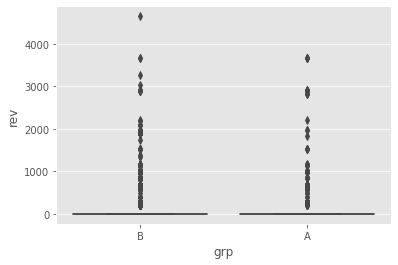

In [34]:
ax = sns.boxplot(x="grp", y="rev", data=result_df)

Aha. If I don't make a mistake then we have a huge amount of overshoots. Then **U-test of Mann-Whitney wasn't a correct choice for the samples**. Let's do Bootstrap.

---

---

---

**РАБОТА НАД ОШИБКАМИ в этом задании:**

**блок 2 из 4**

Согласно замечаний Олега Цыбикова, "ничего удивительного, что Манн-Уитни оказался не значимым (мягко говоря) — в обеих выборках огромная доля нулей". И действительно! Большая доля одинаковых значений "уравнивает" выборки, делает их все более и более похожими друг на друга. Но при первоначальном решении, возможно из-за невнимательности, эта действительно очевидная мысль не пришла мне в голову. Поэтому для исправления этого считаю нужным добавить этот блок с пояснением.

**КОНЕЦ РАБОТЫ НАД ОШБКАМИ этого задания в блоке 4 из Х**

---

---

---

But for what statistics?



As I know, Bootstrap on different statistics may vary more or less, that's why we should determine the statistics before the test, otherwise, we can do some adjust-values-work. Personally I don't have such knowledge and experience to answer this question clearly and unambiguous, but smth tells me that in this case (where we have almost the same amount of overshoots in both samples and similat std deviations in them) it's possible to use Mean.

*If you don't mind I'm gonna use a pre-ready code.*

**!!! Внимание:**

*Pre-ready code будет использован с русскими комментариями.*

## Bootstrap

In [35]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap_mean(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

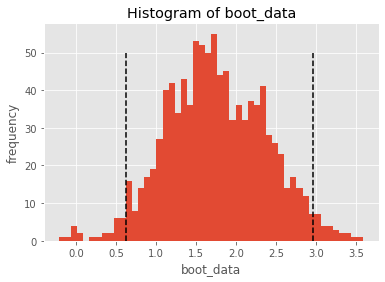

In [36]:
booted_data_mean = get_bootstrap_mean(B_df.rev, A_df.rev)

In [37]:
booted_data_mean['p_value']

0.004479539415831214

It tells us groups differ.

For completed analysis let's conduct one more test with active users only. 

---

---

---

**РАБОТА НАД ОШИБКАМИ в этом задании:**

**блок 3 из 4**

Уточняю предыдущий блок MarkDown : "For completed analysis let's conduct one more test with active users only."

Мы проведем не один тест, а дополним его еще следующими:
- по метрике ARPPU, т.е. только на платящих пользователях, сделаем еще один тест, тоже по bootstrap (чтобы сохранялась унифицированность эксперимента с изначальной метрикой);
- попробуем посчитать конверсию (см. в блоке 1).

**КОНЕЦ РАБОТЫ НАД ОШБКАМИ этого задания в блоке 3 из 4**

---

---

---

## Only active users

In [38]:
B_active_df = B_df.query('was_active == True')

In [39]:
A_active_df = A_df.query('was_active == True')

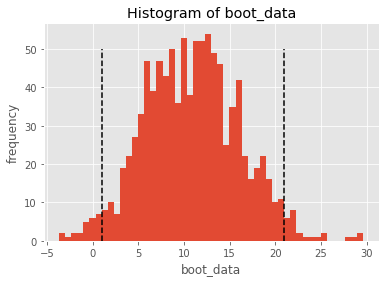

In [40]:
booted_data_active_mean = get_bootstrap_mean(B_active_df.rev, A_active_df.rev)

In [41]:
booted_data_active_mean['p_value']

0.034507287790656184

Groups differ but in a less extent than results on all of the data.
But it can be so because when we test all of the data we take both Active and "Passive" users, and among the last ones the quantity of not paying users, we should assume, is greater than among Active users (see below). That's why the quantity of not paying users can effect on the test results in this way: decrease difference (more users with 0 revenue).

In [42]:
print('1) ', (B_active_df.shape[0] - B_active_df.query('rev > 0').shape[0]) / B_active_df.shape[0] * 100)
# те, кто не платят из активных в тестовой группе
print('2) ', (A_active_df.shape[0] - A_active_df.query('rev > 0').shape[0]) / A_active_df.shape[0] * 100)
# те, кто не платят из активных в контрольной группе

B_passive_df = B_df.query('was_active == False')
A_passive_df = A_df.query('was_active == False')

print('3) ', (B_passive_df.shape[0] - B_passive_df.query('rev > 0').shape[0]) / B_passive_df.shape[0] * 100)
# те, кто не платят в пассивной тестовой группе
print('4) ', (A_passive_df.shape[0] - A_passive_df.query('rev > 0').shape[0]) / A_passive_df.shape[0] * 100)
# те, кто не платят в пассивной контрольной группе

1)  95.38438924004116
2)  94.92847854356306
3)  99.77392614920875
4)  99.77955150133029


---

---

---

**РАБОТА НАД ОШИБКАМИ в этом задании:**

**блок 4 из 4**

Итак, приступим к дополнительным тестам. Напомню, что это:
- Сделаем bootstrap по ARPPU;
- Попробуем посчитать "конверсию в покупку" (согласно замечаниям проверяющего работу - Олега Цыбикова).

## Bootstrap по метрике ARPPU

In [43]:
# Делаем выборку только по платящим пользователям
B_paying_df = B_df.query("rev != 0")
A_paying_df = A_df.query("rev != 0")

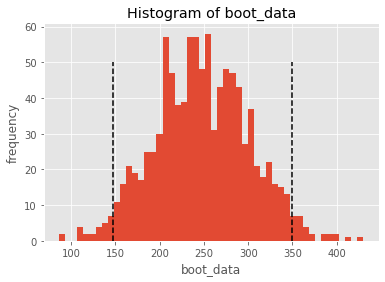

In [44]:
booted_data_mean = get_bootstrap_mean(B_paying_df.rev, A_paying_df.rev)

In [45]:
booted_data_mean['p_value']

3.0324789356291067e-06

In [46]:
if booted_data_mean['p_value'] < 0.05:
    print('Да, среднее от booted_data < 0.05')

Да, среднее от booted_data < 0.05


Итак, bootstrap по платящим пользователям показывает, что группы тестовая и контрольная статистически значимо различаются. Забегая вперед, отмечу, что эти результаты не сильно влияют на уже сделанный вывод.

Теперь попробуем разобраться с запрошенной проверяющим Олегом Цыбиковым конверсией в покупку.

Что такое конверсия? Конверсия - это отношение числа пользователей выполнивших целевое действие к числу всех "пришедших" пользователей. Что в нашем случае "целевое действие" и "число всех пользователей"?
- Целевое действие, согласно замечанию Олега, - это покупка. Какую покупку совершают наши пользователи? Ту, что отражена в колонке rev.
- Число всех пользователей - число строк в колонке rev.

Хорошо. Тогда посчитаем конверсию в покупку в контрольной и тестовой группах по следующей формуле:

*{Конверсия в покупку} = {Число пользователей с rev!=0}/{Число всех пользователей}*

In [47]:
conv_in_B = B_paying_df.student_id.count() / B_df.student_id.count() * 100  # целевая группа
print('Конверсия в целевой группе: ', conv_in_B.round(2), '%')

conv_in_A = A_paying_df.student_id.count() / A_df.student_id.count() * 100  # контрольная группа
print('Конверсия в контрольной группе: ', conv_in_A.round(2), '%')

Конверсия в целевой группе:  0.72 %
Конверсия в контрольной группе:  0.73 %


Как мы видим, разница в значениях конверсий составляет 0.01, что говорит нам, что конверсии мало отличаются.

Однако данный тест я сделал именно под влиянием замечания Олега, т.к. сам я даже сейчас не могу понять, как это полученное знание может быть мною использовано и получено ли оно верно. Хотелось бы это обсудить.

**КОНЕЦ РАБОТЫ НАД ОШБКАМИ этого задания в блоке 4 из 4**

---

---

---

## Conclusion

Bootstrap method **on the targeted ARPU (added during the correction work)** tells us we have a significant difference btw Test and Control groups. That's why if:
- the division of users on control and test groups was correct (e.g. randomly obtained)
- the data was collecting in a right way (e.g. sufficient period of time)
- etc.

then we should launch the new "Pay Path" for all users.

## Задача 2

Есть таблица: peas

Есть колонки:
- st_id   -- ID ученика
- timest  -- Время решения карточки
- correct -- Правильно ли решена горошина?
- subject -- Дисциплина, в которой находится горошина

Усердный ученик - это тот, у которого:
- хотя бы 1 раз за месяц правильно решено 20 горошин за час.

In [ ]:
# Изначальное условие
st_id - int - ID ученика
timest - timestamp - Время решения задания
correct - bool - Правильно ли решено задание

усердный ученик - тот, который хотя бы раз за текущий месяц правильно решил 20 задач за час

Дать информацию о количестве очень усердных студентов за март 2020 года

### Objective

Найти количество усердных учеников за март 2020.

## Решение

Готовим данные.
- отсеиваем данные по колонке timest так, чтобы остались только данные за март 2020.
- берем в колонку spent общее кол-во минут, потраченных на выполнение задания, из данных колонки timest для каждого пользователя.

In [ ]:
SELECT
    st_id AS ID,
    minute(timest)+(minute(timest)*60) AS spent,
    correct
FROM some_database.peas
WHERE
    month(timest) = 3
    AND year(timest) = 2020

LIMIT 100

- считаем скользящую сумму по колонкам spent и correct (далее будем агрегировать их по ID).
- теперь у нас есть для каждого ID массивы с накопительными значениями потраченного времени и решенных задач.
- тогда нам остается найти время решения десятой задачи.
- для обоих массивов (что в колонке spent, что в колонке correct) порядок значений сохранен так, что, если мы в массиве correct найдем порядковый номер 20, то по этому же номеру мы сможем отыскать время, затраченное студентом для достижения этих 20 правильно решенных задач, из массива spent.
- поэтому мы создаем условие вывода после заданной агрегации тех строк, у которых
    - во-первых, число 20 вообще есть среди значений массивов колонки solved_cumulative: indexOf(solved_cumulative,20) > 0
    - во-вторых, эти 20 задач решены за время не более часа: spent_cumulative[indexOf(solved_cumulative,20)] <= 60
- и выводим из полученных данных только ID

In [ ]:
SELECT ID
FROM
    (
    SELECT 
        ID,
        groupArrayMovingSum(spent) AS spent_cumulative,
        groupArrayMovingSum(correct) AS solved_cumulative
    FROM
        (
        SELECT
            st_id AS ID,
            minute(timest)+(minute(timest)*60) AS spent,
            correct
        FROM some_database.peas
        WHERE
            month(timest) = 3
            AND year(timest) = 2020
        )
    GROUP BY ID
    HAVING 
        indexOf(solved_cumulative,20) > 0
        AND spent_cumulative[indexOf(solved_cumulative,20)] <= 60
    ORDER BY ID
    )
-- однако есть опасения, что нужна была сортировка вида ID, timest, чтобы упорядочить значения.

---

---

---

**РАБОТА НАД ОШИБКАМИ в этом задании:**

В этой задаче сказано "найти количество" таких учеников. Мой же запрос выводит только их ID.

Соответственно, мне нужно в текущем результате запроса лишь посчитать количество (уникальных, на всякий случай) ID и вывести это значение.

Таким образом, финальный мой ответ на поставленное условие в задании - ниже:

In [ ]:
SELECT count (DISTINCT ID)
FROM
    (
    SELECT 
        ID,
        groupArrayMovingSum(spent) AS spent_cumulative,
        groupArrayMovingSum(correct) AS solved_cumulative
    FROM
        (
        SELECT
            st_id AS ID,
            minute(timest)+(minute(timest)*60) AS spent,
            correct
        FROM some_database.peas
        WHERE
            month(timest) = 3
            AND year(timest) = 2020
        )
    GROUP BY ID
    HAVING 
        indexOf(solved_cumulative,20) > 0
        AND spent_cumulative[indexOf(solved_cumulative,20)] <= 60
    ORDER BY ID
    )
-- однако есть опасения, что нужна была сортировка вида ID, timest, чтобы упорядочить значения.

**Внимание:**

!!!: *Далее идет блок лишь для обсуждения возможного дополнительного решения этой задачи.*

Честно признаюсь, я попросил помощи у своего друга: попросил его написать такой запрос, который отражал бы его видение на решение этой задачи. При этом я упростил начальную задачу, приведя ее к подобной. В итоге, придерживаясь его "пайплайна" решения, на основе его кода, и сублимируя это с начальным условием задачи, я получил такой запрос: 

In [ ]:
SELECT ID
FROM (
    SELECT  ID,
            time,
            rn,
            sum(time) over (partition by ID order by ID, rn) as sum_time
    FROM (
        SELECT ID,
                time,
                row_number() over (partition by ID order by time) as rn
        FROM (
            SELECT ID, time
            FROM (
                SELECT
                    st_id AS ID,
                    minute(timest)+(minute(timest)*60) AS time,
                    correct
                FROM some_database.peas
                WHERE
                    month(timest) = 3
                    AND year(timest) = 2020
            ) as table
            WHERE correct = 1
        ) as only_correct_answers
    ) as order_by_low_time
) as sum_time_in_one_id
WHERE rn = 20 and sum_time < 60;

Хотелось бы обсудить его вместе со знающим и компетентным человеком :)

Мои мысли:

Судя по тому, как мне объяснил друг, его запрос делает следующее:
- он отбирает только данные с правильными ответами учеников,
- далее посредством оконных функций суммирует данные по времени и решенным задачам,
- и отбирает те ID, в данных которых 20 решенных задач и время до 60 минут.

Чем отличается такой алгоритм от представленного моего?

Дело в том, что если мы представим такую ситуацию, что ученик: 1) сделал, к примеру, первую задачу за 5 минут, 2) затем вторую задачу он решал с несколькими неудачными попытками: при первой попытке он потратил 20 мин и не решил (correct = 0), при второй - 10 мин и не решил, а при третьей - 5 мин и отправил, наконец, верный ответ (correct = 1), - то решение друга выдаст, что ученик решил эти две задачи за 10 мин (5 мин от первой задачи + 5 мин от третьей попытки второй задачи). При этом думая над своим решением, я пытался сделать так, чтобы в итоге мой запрос показал бы решение двух задач в этом случае за (5+20+10+5) 40 мин. Ведь не зря же нам данные именно в формате TimeStamp даны - чтобы мы имели, так скажем, абсолютное значение времени. Но условие задачи не уточняет этот момент. Поэтому я и привожу здесь это решение для обсуждения.

Спасибо большое, если проверите и его.

**КОНЕЦ РАБОТЫ НАД ОШБКАМИ в этом задании**

---

---

---

## Задача 3

## Условие

Реализовать функцию, 

которая будет **автоматически** подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться)

и на основании дополнительных параметров пересчитывать метрики.

## Решение

Так как в решении **Задачи 1** никаких особых метрик для проверки A/B теста не использовалось, а только проводился Bootstrap, то попробую реализовать функцию, способную автоматически подгружать данные и самостоятельно проводить Bootstrap.

- т.е., мы уже имеем наш датафрейм со всеми результатами, который мы сделали в Задании1 (пусть это result_df.csv).
- а запуская функцию, python сам должен найти файл (groups_add.csv), выгрузить из него данные, добавить их в result_df.csv, обработать, дать оценку.
- также я делаю допущение, что в groups_add.csv помимо колонок из первого задания (id, grp) есть и rev. Должна быть rev, так как по ней мы и считаем успешность новых фич, а в условии не сказано, что нам дается новый файл для checks.

In [1]:
def get_updated_stat():
    # import all necessary modules
    # modules for getting data
    import requests
    from urllib.parse import urlencode
    # std
    import pandas as pd
    import numpy as np
    # for bootstrap
    from scipy.stats import norm
    from tqdm.auto import tqdm
    
    # download new data
    project_2_goup_add = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
    public_key = project_2_goup_add  # Сюда вписываете ссылку
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    with open('project_2_goup_add.csv', 'wb') as f:   # Здесь - путь к файлу
        f.write(download_response.content)
    
    # open previous result data and new data as a Data Frame
    result_df = pd.read_csv('result_df.csv')
    # start columns: student_id, grp, was_active, rev
    groups_add_df = pd.read_csv('project_2_goup_add.csv', names=['student_id', 'grp', 'rev'])
    # start columns: id, grp, rev, - but their exact names can be different
    
    # prepare data fot bootstrap
    result_df.drop(columns=['was_active'])  # after that we have identical columns
    result_df = pd.concat([result_df, groups_add_df], axis=0)  # and a general DataFrame with a new data
    A_df = result_df.query('grp == "A"')  # control grp
    B_df = result_df.query('grp == "B"')  # test grp
    
    # do bootstrap
    # some init data for bootstrap
    data_column_1 = B_df.rev,  # числовые значения первой выборки
    data_column_2 = A_df.rev,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости    
    # bootstrap itself
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values

        boot_data.append(statistic(samples_1 - samples_2))
        # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
#         # Визуализация
#     plt.hist(pd_boot_data[0], bins = 50)
    
#     plt.style.use('ggplot')
#     plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
#     plt.xlabel('boot_data')
#     plt.ylabel('frequency')
#     plt.title("Histogram of boot_data")
#     plt.show()

    if p_value < 0.05:
        print('Контрольная и Тестовая группы, данные по которым обновлены, ',
              'статистически значимо различаются./n')
    else:
        print('Контрольная и Тестовая группы, данные по которым обновлены, ',
              'статистически НЕ различаются./n')
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}


---

---

---

**РАБОТА НАД ОШИБКАМИ в этом задании:**

В замечании к выполнению этого задания Олег дал такую формулировку:

"Подгружается groups_add, который имеет ту же структуру, что и groups (айдишник и метка группы, столбца rev там нет и быть не должно)...".

Данные в groups и groups_add имеют следующую структуру:

колонки: | {id ученика} | {группа: целевая/контрольная} |

По этим данным что мог бы я посчитать, какие метрики посмотреть?
- отношение количества учеников целевой группы ко всем ученикам? - Да, легко.
- конверсию в покупку? - Нет, для этого мне пришлось бы "смерджить" эти данные (подгружаемые) с данными о revenue. Что я и реализовал в своем первоначальном напсании функции. Но данные о revenue, по замечанию Олега, подгружать не нужно. Значит, конверсию я не смогу посчитать.
- ARPU/ARPPU? - Ну, точно не смогу посчитать. Для них нужна колока |{выручка}|, которую подгружать не нужно.
- сделать bootstrap? - Но по какой колонке? По |{id ученика}| и |{группа: целевая/контрольная}| этого делать не имеет смысла.

Поэтому я считаю, что моя функция валидна и для текущего замечания. К тому же разные имена колонок я также учел, о чем свидетельствуют:
- комментарий в группе "# open previous result data and new data as a Data Frame", который гласит: "# start columns: id, grp, rev, - but their exact names can be different";
- манипуляции с данными посредством кода в блоке функции под комментарием "# prepare data fot bootstrap".

Я бы очень хотел обсудить это задание при голосовом общении.

**КОНЕЦ РАБОТЫ НАД ОШБКАМИ в этом задании**

---

---

---